In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from sklearn import preprocessing
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
import time
import nltk
import warnings
warnings.filterwarnings("ignore")


In [52]:
df = pd.read_excel("C:/Users/jllce/Downloads/classificacao_assuntos.xlsx")

In [53]:
df = df[~df['label'].isnull()]
df 

,tweets,label
0,Nunca mais compro nada na @petlovebr bicho,Outro
1,a entrega expressa da @PetzOficial é qualquer ...,Entrega
2,@PetzOficial cadê a reação dos meu filhos que...,Entrega
3,E a @petlovebr que mandou os sachês dos meus g...,Entrega
4,A @petlovebr fazendo um péssimo atendimento em...,Atendimento
...,...,...
21028,Encontrei uma loja aqui em natawn na qual vou ...,Loja Virtual
21035,a entrega da @petlovebr é a mais rápida que eu...,Entrega
21036,"A @petlovebr nunca atrasou uma entrega, já a @...",Entrega
21038,Na eterna dúvida se compro a areia da Tutu que...,Entrega


In [54]:
df1 = df["tweets"]
df2 = df["label"]

In [55]:
def cleanTxt(text):
  import re
  text = text.lower()
  text = re.sub(r"@([a-zA-Z0-9_]{1,50})",'',str(text)) 
  text = re.sub(r'(?:\@|https?\://)\S+','',text)
  text = re.sub(r'\d+','', text)
  text = re.sub(r"[-()\"#/;:<>{}-~=|.?,]","",text)
  return text

def removeEmojis(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  return text

def removeStopWords(text):
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [stemmer.stem(i) for i in text.split() if not i in stopwords]
    return (" ".join(words))


tweets_tratados = df1.apply(cleanTxt)
tweets_tratados = tweets_tratados.apply(removeEmojis)
tweets_tratados = tweets_tratados.apply(removeStopWords)
tweets = list(tweets_tratados)

In [56]:
label_encoder = preprocessing.LabelEncoder()
labels = pd.DataFrame(label_encoder.fit_transform(df2), columns=["Label"], index = df.index)
labels

,Label
0,3
1,1
2,1
3,1
4,0
...,...
21028,2
21035,1
21036,1
21038,1


In [57]:
labels.value_counts()

Label
1        3997
4        1899
2        1592
0        1183
3         471
dtype: int64

In [58]:
from keras.utils.np_utils import to_categorical
y = to_categorical(labels)

In [59]:
y.shape

(9142, 5)

In [60]:
# prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [61]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8183 unique tokens.


In [64]:
# integer encode the documents
sequences = tokenizer.texts_to_sequences(tweets)

In [65]:
# pad documents to a max length of 14 words
maxlen = 14
X = pad_sequences(sequences, maxlen=maxlen)

In [66]:
X.shape

(9142, 14)

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [68]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6399, 14), (2743, 14), (6399, 5), (2743, 5))

In [73]:
# SimpleRNN
vocab_size = len(word_index) + 1
output_dim = 32
maxlen = maxlen
model = Sequential()
model.add(Embedding(vocab_size, output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [74]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 14, 32)            261888    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 14, 32)            2080      
                                                                 
 dropout_6 (Dropout)         (None, 14, 32)            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 14, 32)            2080      
                                                                 
 dropout_7 (Dropout)         (None, 14, 32)            0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 5)                

In [75]:
model.save('srnn.h5')

In [76]:
start = time.time()

# Fit the model to the training set
rnn_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10
140/140 [==============================] - 8s 25ms/step - loss: 1.3855 - accuracy: 0.4146 - val_loss: 1.2741 - val_accuracy: 0.4828
Epoch 2/10
140/140 [==============================] - 3s 22ms/step - loss: 0.9993 - accuracy: 0.5992 - val_loss: 1.0057 - val_accuracy: 0.6286
Epoch 3/10
140/140 [==============================] - 3s 20ms/step - loss: 0.6620 - accuracy: 0.7763 - val_loss: 1.0360 - val_accuracy: 0.6391
Epoch 4/10
140/140 [==============================] - 3s 20ms/step - loss: 0.4146 - accuracy: 0.8701 - val_loss: 1.0480 - val_accuracy: 0.6526
Epoch 5/10
140/140 [==============================] - 3s 20ms/step - loss: 0.2585 - accuracy: 0.9230 - val_loss: 1.2636 - val_accuracy: 0.6385
Epoch 6/10
140/140 [==============================] - 3s 22ms/step - loss: 0.1652 - accuracy: 0.9529 - val_loss: 1.3458 - val_accuracy: 0.6307
Epoch 7/10
140/140 [==============================] - 3s 21ms/step - loss: 0.1134 - accuracy: 0.9696 - val_loss: 1.4687 - val_accuracy: 0.6411

In [77]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [78]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 14, 32)            261888    
                                                                 
 lstm_3 (LSTM)               (None, 14, 32)            8320      
                                                                 
 dropout_8 (Dropout)         (None, 14, 32)            0         
                                                                 
 lstm_4 (LSTM)               (None, 14, 32)            8320      
                                                                 
 dropout_9 (Dropout)         (None, 14, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 5)                

In [79]:
model.save('lstm.h5')

In [80]:
start = time.time()
# Fit the model to the training set
lstm_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# Final evaluation of the model
warnings.filterwarnings("ignore")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")
end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10
140/140 [==============================] - 14s 42ms/step - loss: 1.2971 - accuracy: 0.4648 - val_loss: 1.1169 - val_accuracy: 0.5625
Epoch 2/10
140/140 [==============================] - 5s 37ms/step - loss: 0.9633 - accuracy: 0.6155 - val_loss: 0.9957 - val_accuracy: 0.6208
Epoch 3/10
140/140 [==============================] - 5s 32ms/step - loss: 0.7248 - accuracy: 0.7370 - val_loss: 0.9450 - val_accuracy: 0.6427
Epoch 4/10
140/140 [==============================] - 4s 32ms/step - loss: 0.5550 - accuracy: 0.8062 - val_loss: 1.0086 - val_accuracy: 0.6542
Epoch 5/10
140/140 [==============================] - 5s 34ms/step - loss: 0.4231 - accuracy: 0.8640 - val_loss: 1.0226 - val_accuracy: 0.6703
Epoch 6/10
140/140 [==============================] - 5s 34ms/step - loss: 0.3308 - accuracy: 0.8966 - val_loss: 1.0382 - val_accuracy: 0.6917
Epoch 7/10
140/140 [==============================] - 4s 32ms/step - loss: 0.2421 - accuracy: 0.9317 - val_loss: 1.1626 - val_accuracy: 0.695

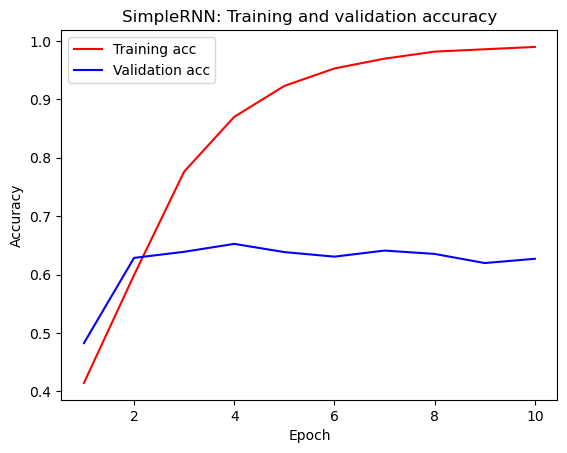

In [81]:
# SimpleRNN Result

acc = rnn_hist.history['accuracy']
val_acc = rnn_hist.history['val_accuracy']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('SimpleRNN: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

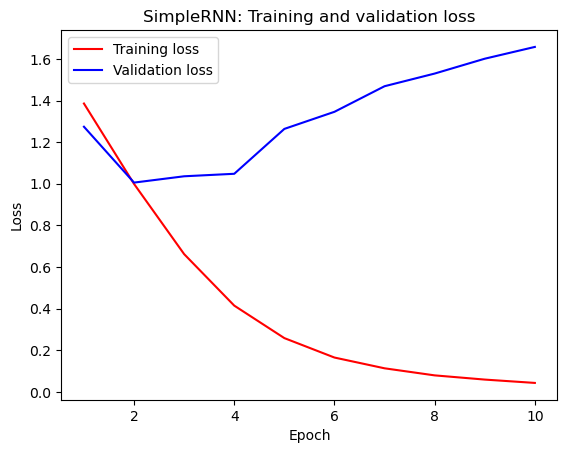

In [82]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('SimpleRNN: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

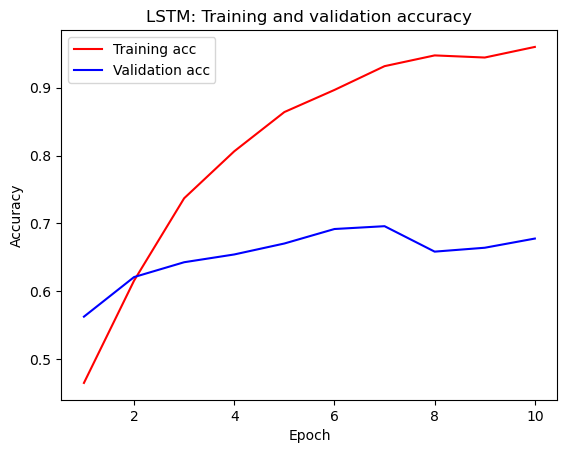

In [83]:
# LSTM Result

acc = lstm_hist.history['accuracy']
val_acc = lstm_hist.history['val_accuracy']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('LSTM: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

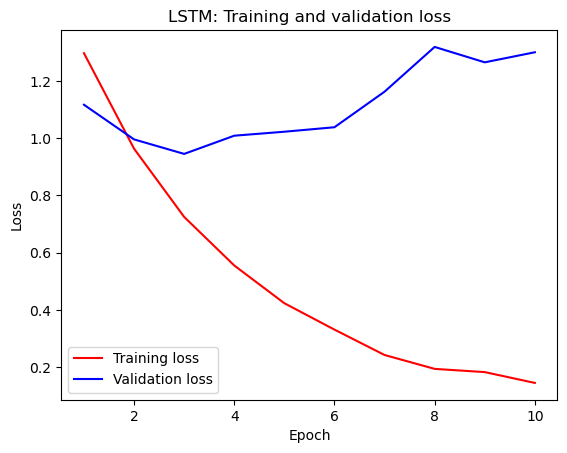

In [84]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

In [85]:
from keras.models import load_model
lstm = load_model('lstm.h5')
warnings.filterwarnings("ignore")

In [86]:
lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 14, 32)            261888    
                                                                 
 lstm_3 (LSTM)               (None, 14, 32)            8320      
                                                                 
 dropout_8 (Dropout)         (None, 14, 32)            0         
                                                                 
 lstm_4 (LSTM)               (None, 14, 32)            8320      
                                                                 
 dropout_9 (Dropout)         (None, 14, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 5)                

In [87]:
predictions = lstm.predict(X_test)

86/86 [==============================] - 3s 10ms/step


In [88]:
probability_positive = predictions[:,1]

In [89]:
len(probability_positive)

2743

In [90]:
probability_positive

array([0.19999024, 0.19995646, 0.19995205, ..., 0.1999952 , 0.20056029,
       0.20058191], dtype=float32)